In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))

In [2]:
set.seed(42)
getwd()

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Myeloid/code"

In [3]:
coembed <- readRDS("../data/coembed/coembed.Rds")
coembed

An object of class Seurat 
131519 features across 25137 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony

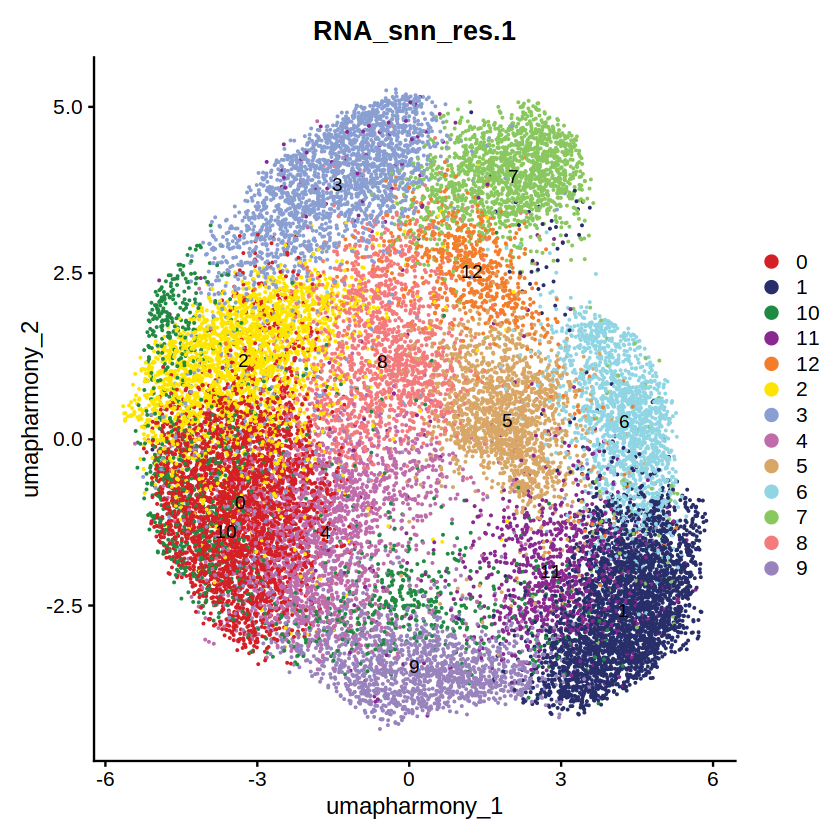

In [4]:
cols <- ArchR::paletteDiscrete(coembed@meta.data[, glue::glue("RNA_snn_res.1")])
DimPlot(coembed, reduction = "umap_harmony", group.by = "RNA_snn_res.1", cols = cols, label = TRUE)

In [5]:
## get number of cells per cluster and sample
df_count <- coembed@meta.data %>%
    as.data.frame() %>%
    subset(., tech == "RNA") %>%
    group_by(orig.ident, RNA_snn_res.1) %>%
    summarise(count = n()) %>%
    tidyr::pivot_wider(names_from = RNA_snn_res.1, values_from = count, values_fill = 0)

write.csv(df_count, "../data/coembed/stat_cell_counts_per_sample_rna.csv", row.names = FALSE)

`summarise()` has grouped output by 'orig.ident'. You can override using the `.groups` argument.



`summarise()` has grouped output by 'RNA_snn_res.1'. You can override using the `.groups` argument.



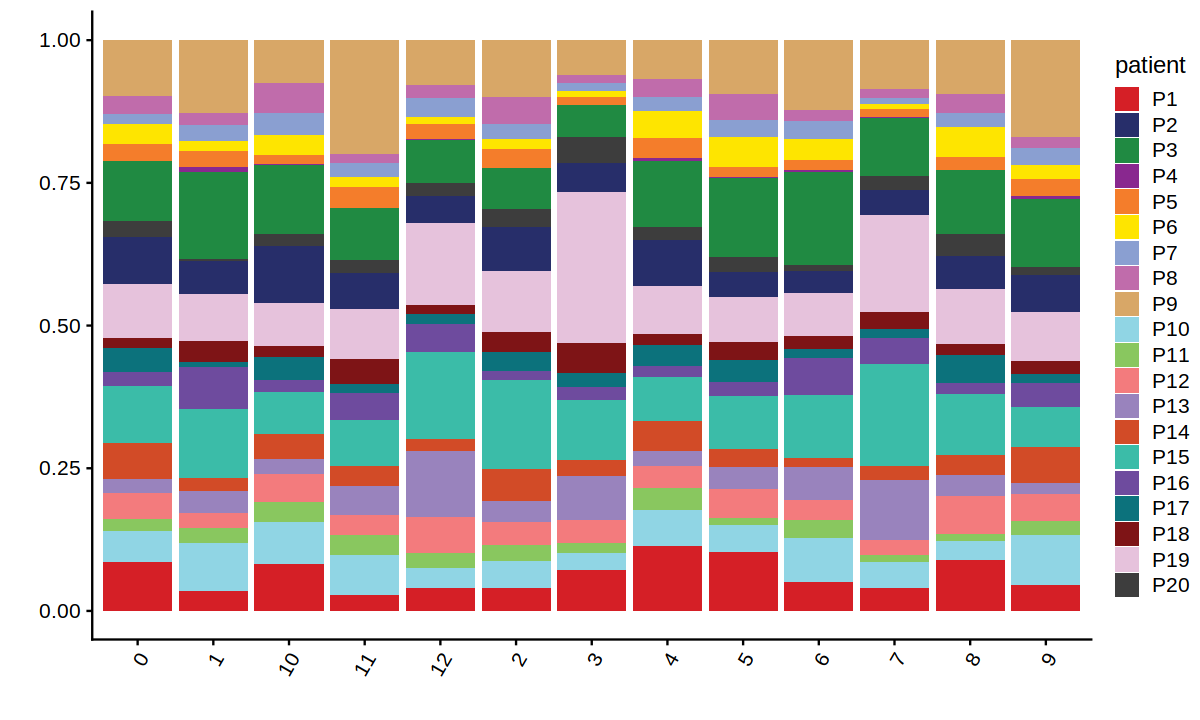

In [6]:
## check cell proportion across patients and modalities
meta.data <- as.data.frame(coembed@meta.data)

cols.patient <- ArchR::paletteDiscrete(meta.data$patient)

df_plot <-  meta.data %>%
    group_by(RNA_snn_res.1, patient) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(RNA_snn_res.1, cell_proportion, fill=patient)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
   scale_fill_manual(values = cols.patient) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'RNA_snn_res.1'. You can override using the `.groups` argument.



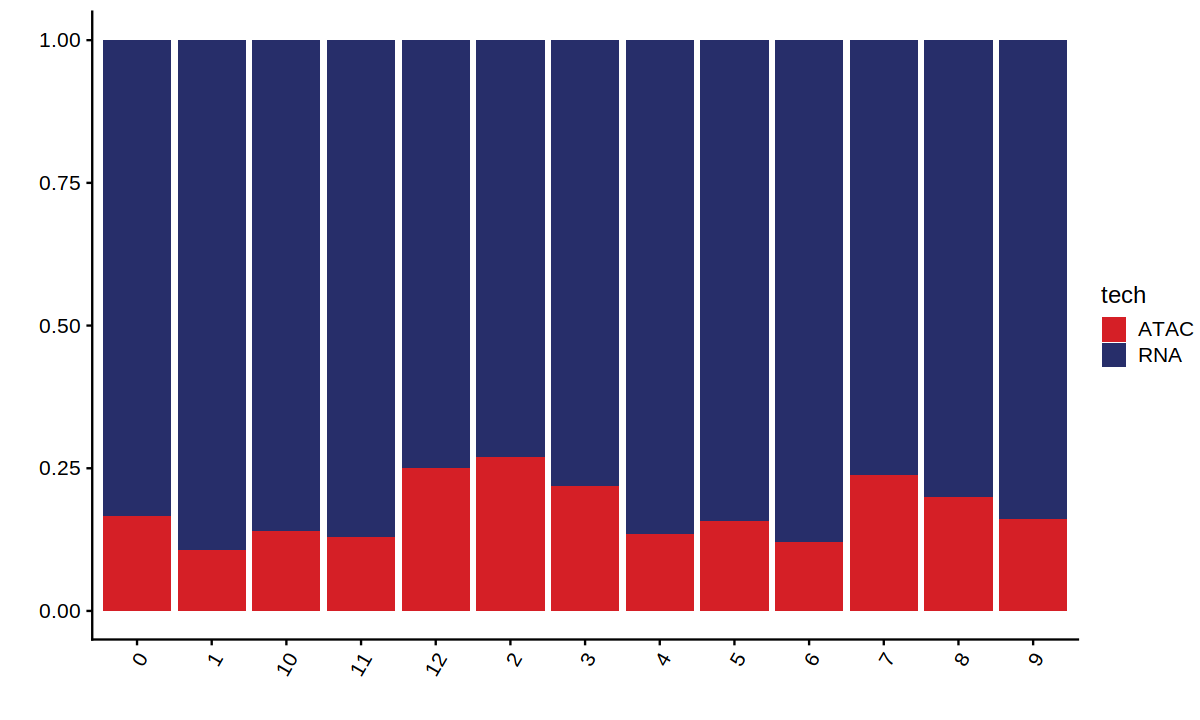

In [7]:
cols.tech <- ArchR::paletteDiscrete(meta.data$tech)

df_plot <-  meta.data %>%
    group_by(RNA_snn_res.1, tech) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(RNA_snn_res.1, cell_proportion, fill=tech)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
   scale_fill_manual(values = cols.tech) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

An object of class Seurat 
131519 features across 17533 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony

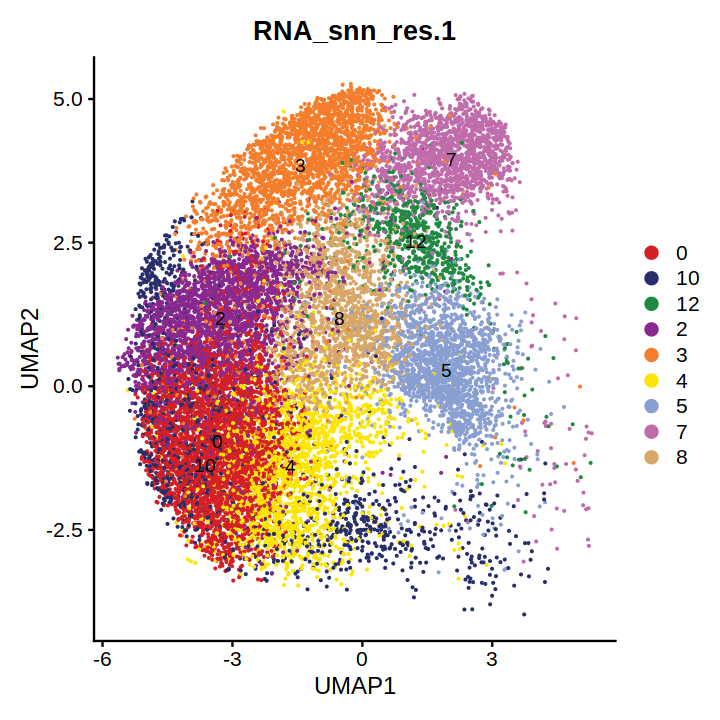

In [8]:
Idents(coembed) <- "RNA_snn_res.1"
coembed.sub <- subset(coembed, idents = c(1, 6, 9, 11), invert = TRUE)
coembed.sub

cols.clusters <- ArchR::paletteDiscrete(coembed.sub@meta.data[, "RNA_snn_res.1"])

options(repr.plot.height = 6, repr.plot.width = 6)

p <- DimPlot(coembed.sub, group.by = "RNA_snn_res.1", label = TRUE,
             reduction = "umap_harmony", shuffle = TRUE, cols = cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

p

In [9]:
coembed.sub <- RunUMAP(coembed.sub, 
               dims = 1:30, 
               reduction = 'harmony',
               reduction.name = "umap_harmony_v2",
               reduction.ke = 'umap_harmony_v2_',
              verbose = FALSE,
                   min.dist = 0.4)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_harmony_v2_ to umapharmonyv2_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to umapharmonyv2_”


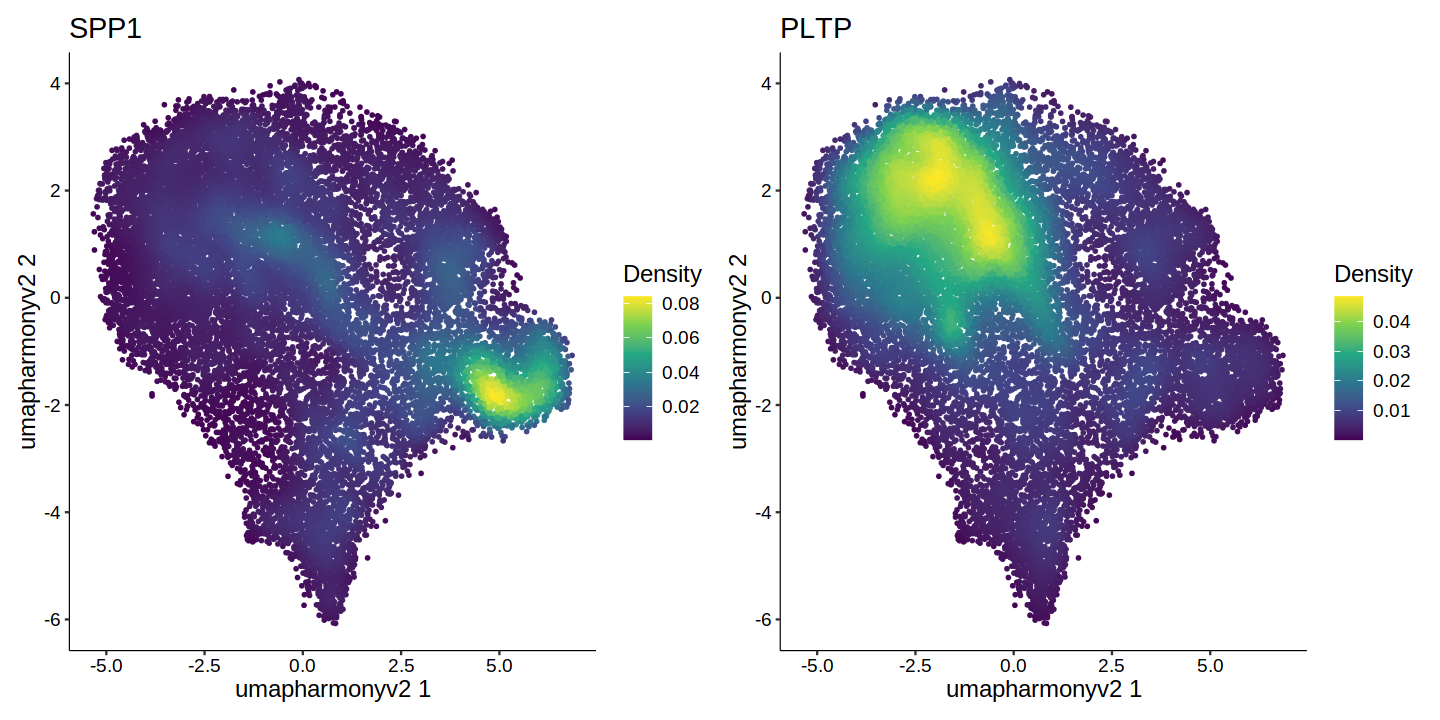

In [10]:
options(repr.plot.height = 6, repr.plot.width = 12)

p1 <- plot_density(coembed.sub, features="SPP1", reduction="umap_harmony_v2")
p2 <- plot_density(coembed.sub, features="PLTP", reduction="umap_harmony_v2")

patchwork::wrap_plots(list(p1, p2), nrow = 1)

In [13]:
## re-clustering
resolutions <- seq(0.1, 1, 0.1)

coembed.sub <- FindNeighbors(coembed.sub, reduction = "harmony", dims = 1:30)
coembed.sub <- FindClusters(coembed.sub, resolution = resolutions, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN



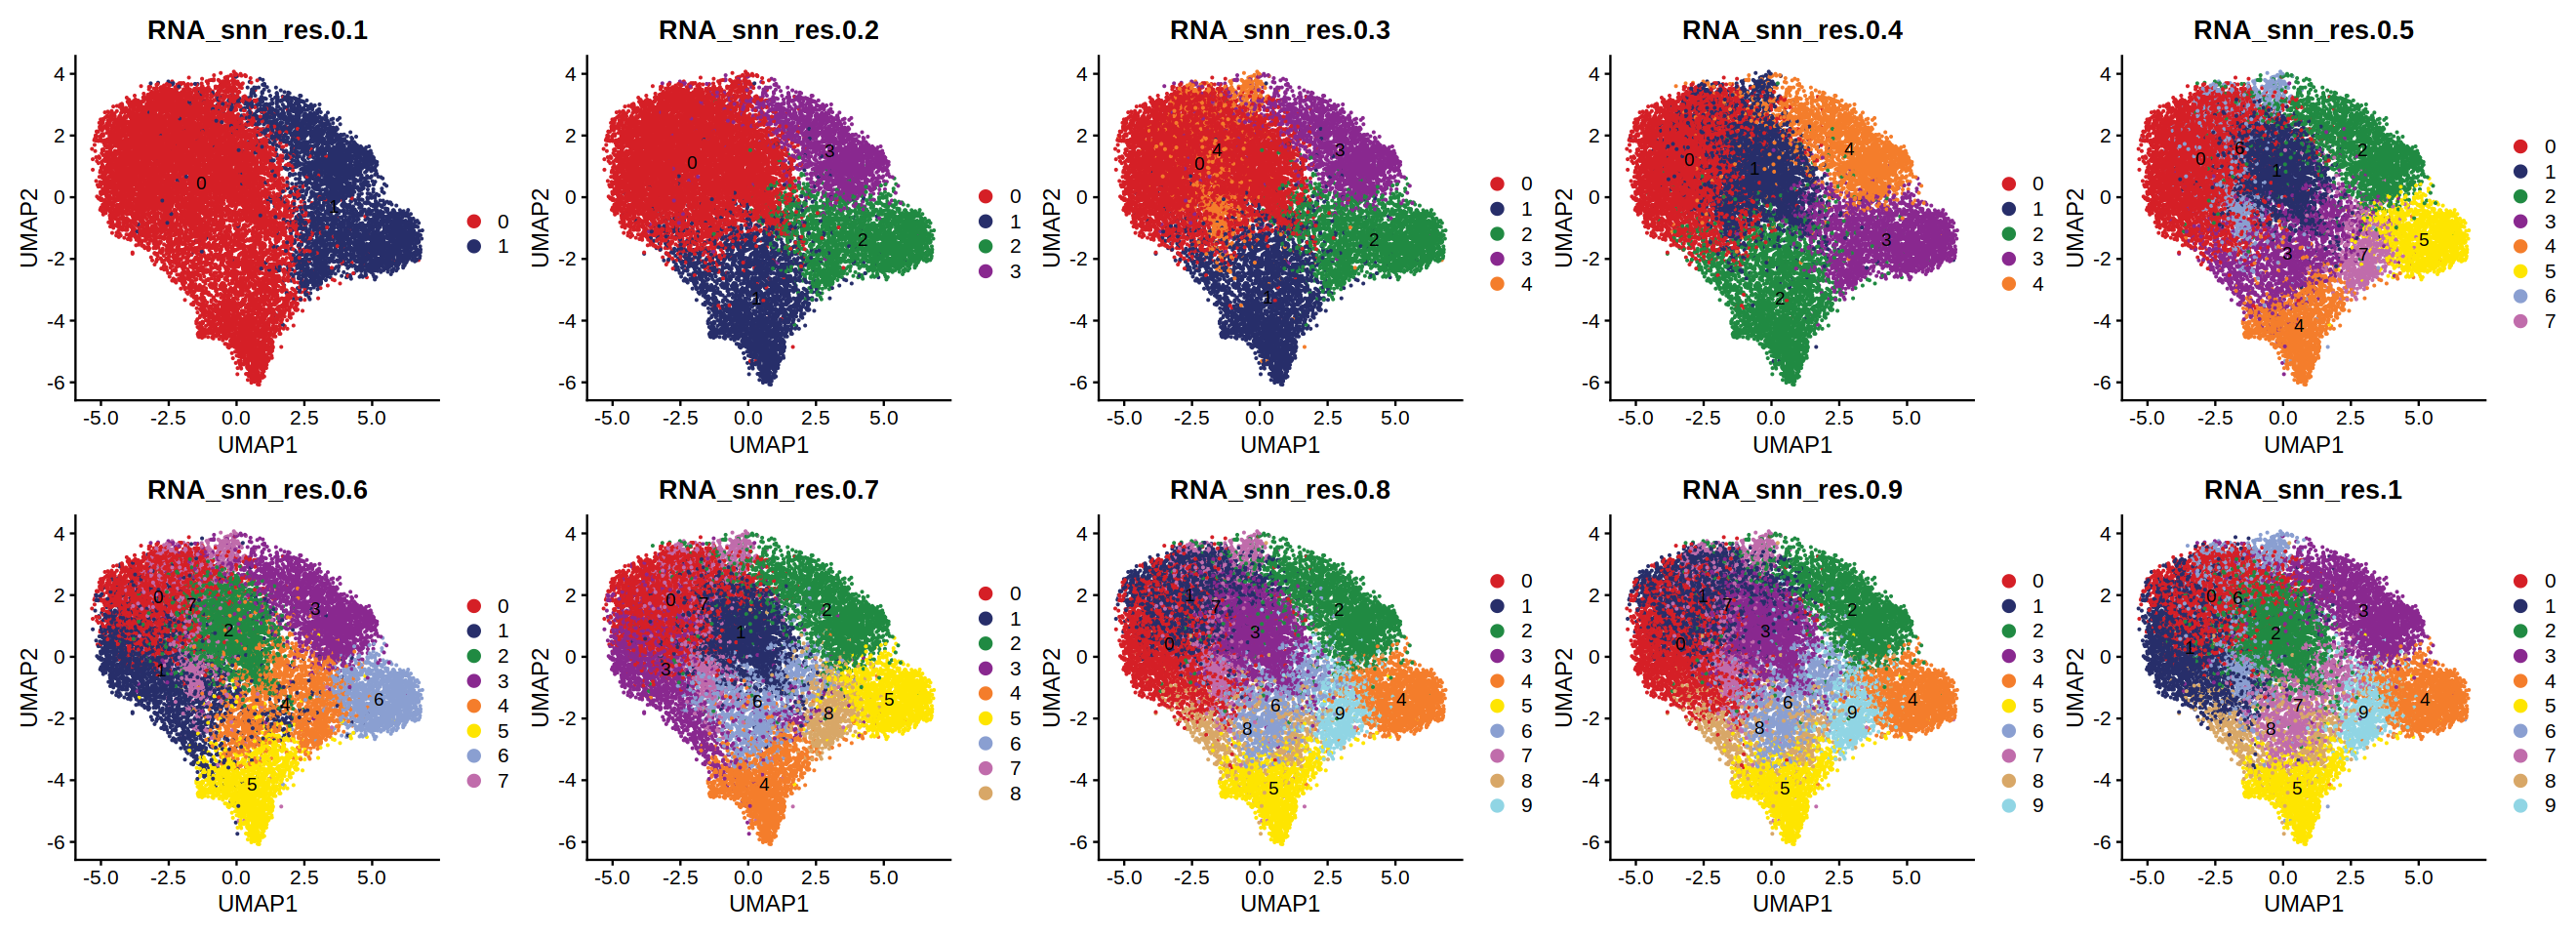

In [14]:
options(repr.plot.height = 8, repr.plot.width = 22)

plotlist <- lapply(resolutions, function(x){
    cols <- ArchR::paletteDiscrete(coembed.sub@meta.data[, glue::glue("RNA_snn_res.{x}")])
    
    p <- DimPlot(coembed.sub, group.by = glue::glue("RNA_snn_res.{x}"), label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE) +
    scale_color_manual(values = cols) +
    xlab("UMAP1") + ylab("UMAP2")
    
    p
})

p <- patchwork::wrap_plots(plotlist, nrow = 2)

p

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 15)

if(!dir.exists("../data/coembed/MarkerGenesAfterCleaning")){
    dir.create("../data/coembed/MarkerGenesAfterCleaning")
}

for(res in resolutions){
    Idents(coembed.sub) <- glue::glue("RNA_snn_res.{res}")
    all.markers <- FindAllMarkers(coembed.sub, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
    
    df <- all.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)
    
    p <- DotPlot(coembed.sub, features = unique(df$gene)) + RotatedAxis() + ggtitle(glue::glue("RNA_snn_res.{res}"))
    
    print(p)
    
    markerList <- split(all.markers, all.markers$cluster)
    
    for(i in 1:length(markerList)){
        markerList[[i]] <- markerList[[i]][order(-markerList[[i]]$avg_log2FC), ]
    }
    
    WriteXLS::WriteXLS(markerList,
                   ExcelFileName = glue::glue("../data/coembed/MarkerGenesAfterCleaning/res.{res}.xlsx"),
                   SheetNames = names(markerList))

    saveRDS(all.markers, glue::glue("../data/coembed/MarkerGenesAfterCleaning/res.{res}.rds"))
}

In [ ]:
saveRDS(coembed.sub, file = "../data/coembed/coembed.cleaning.Rds")

In [ ]:
sessionInfo()